Lacquered Chi-Square:  9.548833822285648
Polished Chi-Square:  141.22146683521348
Rough Chi-Square:  4.855661917095731


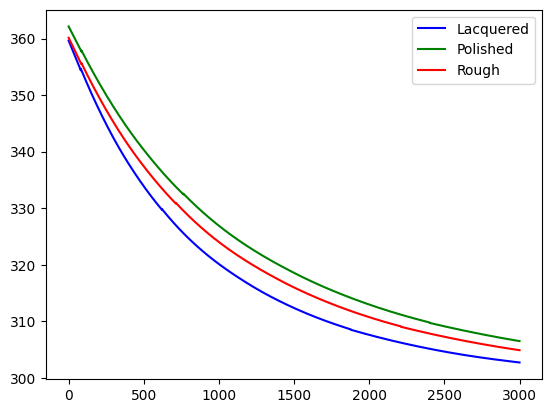

In [41]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

sigma = 5.670374419E-8

emmL = 0.5
emmP = 0.01
emmR = 0.2



rhoAl = 2710
hcAl = 897
Tamb = 25 + 273.15

radL = 12.55E-3
radP = 12.95E-3
radR = 12.95E-3

lengthL = 282E-3
lengthP = 305E-3
lengthR = 304.5E-3

hlengthL = 82.1E-3
hlengthP = 80.1E-3
hlengthR = 80.5E-3

hrad = 3.4E-3

volL = np.pi * radL ** 2 * lengthL - np.pi * hrad ** 2 * hlengthL
volP = np.pi * radP ** 2 * lengthP - np.pi * hrad ** 2 * hlengthR
volR = np.pi * radR ** 2 * lengthR - np.pi * hrad ** 2 * hlengthR

holeA = 3.5E-3 ** 2 * np.pi

saL = 2 * radL * np.pi * lengthL - radL ** 2 * np.pi - holeA
saP = 2 * radP * np.pi * lengthP - radP ** 2 * np.pi - holeA
saR = 2 * radR * np.pi * lengthR - radR ** 2 * np.pi - holeA

massL = rhoAl * volL
massP = rhoAl * volP
massR = rhoAl * volR

TiL = 359.65
TiP = 362.15
TiR = 360.15

y_0L = [TiL]
carrL = [massL, emmL, saL, radL]
y_0P = [TiP]
carrP = [massP, emmP, saP, radP]
y_0R = [TiR]
carrR = [massR, emmR, saR, radR]

y_0arr = [y_0L, y_0P, y_0R]
carrAll = [carrL, carrP, carrR]


def h(T, T_0, r):
    return ((T - T_0) / (2 * r)) ** (1/4)

def dydt_arr(t, y_arr, M, e, A, r):
    """Relates the used physical quantities to their differential
    equations for use in the scipy numerical integration function"""

    T = y_arr[0]

    # dT/dt
    return np.array([(-A * e * sigma * T ** 4 - 1.32 * h(T, Tamb, r) * A * (T - Tamb) + A * e * sigma * Tamb ** 4) / (M * hcAl)])

t_0 = 0
t_f = 3000
steps = int(3E5)
t_arr = np.linspace(t_0, t_f, steps)

steps_per_data = int(3*20 * steps / t_f)


def chi_square(data, model, sigma=2.5):
    return np.sum((model-data)**2/sigma**2)

solarr = []

def model_function(i):
    sol = integrate.solve_ivp(dydt_arr, (t_0, t_f),
                              y_0arr[i],
                              method='LSODA',
                              t_eval=t_arr,
                              args=carrAll[i])

    solT = sol['y'][0]
    solarr.append(solT)


fname = 'experimentdata.csv'

data = np.loadtxt(fname, delimiter=',', comments='#',
                  usecols=(0, 4, 5, 6))

for i in range(3):
    model_function(i)


print("Lacquered Chi-Square: ", chi_square(data[1:, 3], solarr[0][::steps_per_data]))
print("Polished Chi-Square: ",
      chi_square(data[1:, 2], solarr[1][::steps_per_data]))
print("Rough Chi-Square: ",
      chi_square(data[1:, 1], solarr[2][::steps_per_data]))


plt.plot(t_arr, solarr[0], "b")
plt.plot(t_arr, solarr[1], "g")
plt.plot(t_arr, solarr[2], "r")
plt.legend(['Lacquered', 'Polished', 'Rough'])
plt.show()

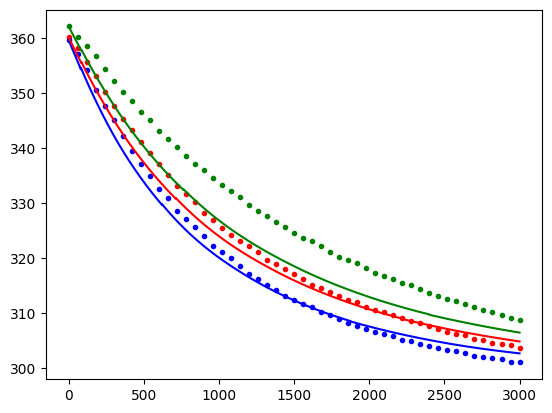

In [42]:
fname = 'experimentdata.csv'
colours = ["r.", "g.", "b."]

data = np.loadtxt(fname, delimiter=',', comments='#',
                  usecols=(0, 4, 5, 6))

x = data[:, 0]
plt.plot(x, data[:, 1], colours[0], x, data[:, 2],
         colours[1], x, data[:, 3], colours[2])

plt.plot(t_arr, solarr[0], "b")
plt.plot(t_arr, solarr[1], "g")
plt.plot(t_arr, solarr[2], "r")
